### Import modules and verify they work? 

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy
import xarray as xr

In [2]:
# general eWC
import ewatercycle
import ewatercycle.models

Download plugin model

In [3]:
# pip install ewatercycle-HBV==1.1.1

#### set up paths

In [4]:
path = Path.cwd()
forcing_path = path / "Forcing"
forcing_path

PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/Forcing')

#### add parameter info

In [5]:
## Array of initial storage terms - we keep these constant for now 
##              Si,  Su, Sf, Ss
s_0 = np.array([0,  100,  0,  5])

## Array of parameters min/max bounds as a reference
##                      Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage"]
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks"]
stor_names = ["Si", "Su", "Sf", "Ss"]

# set initial as mean of max,min
par_0 = (p_min_initial + p_max_initial)/2

In [6]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "2000-08-31T00:00:00Z"

In [7]:
from ewatercycle_HBV.forcing import HBVForcing

In [8]:
test_forcing = HBVForcing(start_time = experiment_start_date,
                          end_time = experiment_end_date,
                          directory = forcing_path,
                          camels_file = "test_forcing.txt",
                          )

In [9]:
ds = test_forcing.to_xarray()

# run containerised model

In [10]:
from ewatercycle_HBV.model import HBV

In [11]:
from ewatercycle.container import ContainerImage
model = HBV(forcing=test_forcing)

In [12]:
config_file, _ = model.setup(
            parameters=','.join([str(p) for p in par_0]),
            initial_storage=','.join([str(s) for s in s_0]),
           )
model.initialize(config_file)

In [13]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q"))
    time.append(pd.Timestamp(model.time_as_datetime.date()))

In [14]:
df = pd.DataFrame(data=Q_m,columns=["Modeled discharge"],index=time)

In [15]:
Q_m_in_ref = np.loadtxt("Q_m_out_ref.txt")

In [16]:
def calc_NSE(Qo, Qm):
    """Calculates Nash-Sutcliffe Efficiency given set of observations (Qo) and model run result (Qm)"""
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((Qm - Qo)**2)
    ErrDo = np.sum((Qo - QoAv)**2)
    return 1 - (ErrUp / ErrDo)

In [17]:
NSE_Q_m_ref = calc_NSE(ds["Q"].values,Q_m_in_ref)

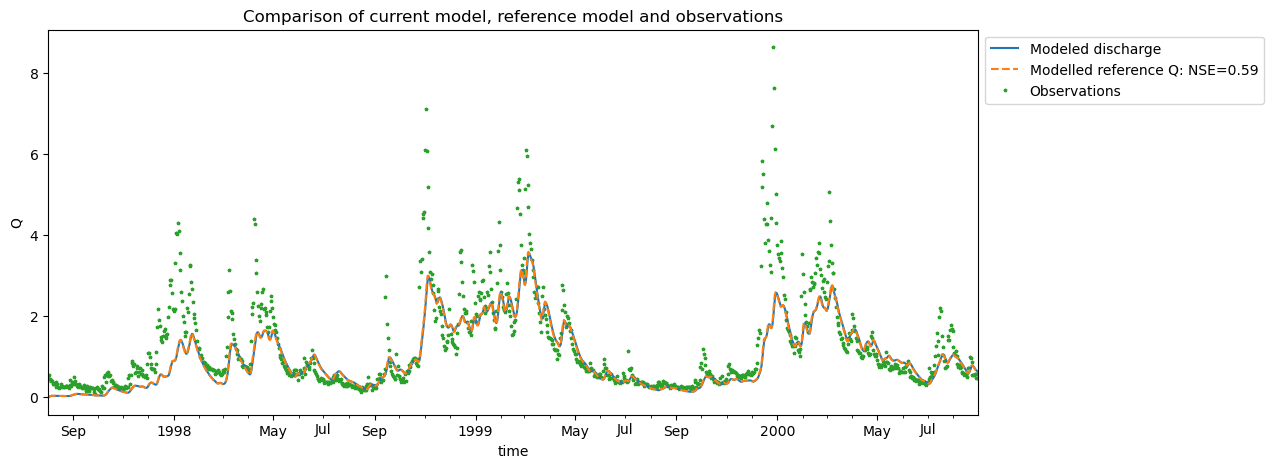

In [18]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
df.plot(ax=ax,label="Modeled discharge HBV-bmi")
ax.plot(df.index, Q_m_in_ref[:-1],ls="--",label=f"Modelled reference Q: NSE={NSE_Q_m_ref:.2f}");
ds["Q"].plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=-1,label="Observations")
ax.legend(bbox_to_anchor=(1,1))
ax.set_title("Comparison of current model, reference model and observations");

In [19]:
df['Modeled discharge'].values[df['Modeled discharge'].values - Q_m_in_ref[:-1] != 0]

array([0.00200467, 0.00802432, 0.01816763, ..., 0.65892438, 0.64108452,
       0.62305975])

In [20]:
model.finalize()

# Run for an ensemble

In [21]:
n_particles = 10

In [22]:
# for initial run sample a set of parameters - start with simpel linear random:  min+[0,1] * (max-min) -> easily changes after
array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])
p_intial = p_min_initial + array_random_num * (p_max_initial-p_min_initial)

In [23]:
ensemble = []
for i in range(n_particles):
    ensemble.append(HBV(forcing=test_forcing))

In [24]:
for index, ensembleMember in enumerate(ensemble):
    config_file, _ = ensembleMember.setup(
                                          parameters=','.join([str(p) for p in p_intial[index]]), 
                                          initial_storage=','.join([str(s) for s in s_0])
                                         )
    ensembleMember.initialize(config_file)

In [25]:
## TODO: fix file system makeing 100000 models? 

In [26]:
ref_model = ensemble[0]
ref_model.time_units

'seconds since 1970-01-01 00:00:00.0 +0000'

In [27]:
ref_model.time_step # should be 86400 = 24 * 3600 = 1 d

86400.0

In [28]:
ref_model = ensemble[0]
n_timesteps = int((ref_model.end_time - ref_model.start_time) / ref_model.time_step) # ref_model.timestep 

In [29]:
n_storage_terms = len(s_0)

In [30]:
Q_m_arr = np.zeros((n_particles,n_timesteps))
storage_terms_arr = np.zeros((n_particles, n_timesteps, n_storage_terms))

In [31]:
time = []
t_index = 0 
# run model
while ref_model.time < ref_model.end_time:
    time.append(pd.Timestamp(ref_model.time_as_datetime.date()))
    for index, ensembleMember in enumerate(ensemble):
        ensembleMember.update()
        Q_m_arr[index, t_index] = ensembleMember.get_value("Q")[0]
        storage_terms = np.array([ensembleMember.get_value("Si"),ensembleMember.get_value("Su"),ensembleMember.get_value("Sf"),ensembleMember.get_value("Ss")]).flatten()
        storage_terms_arr[index, t_index] = storage_terms
    t_index+=1 

# close containers
for index, ensembleMember in enumerate(ensemble):
    ensembleMember.finalize()

In [32]:
# time

In [33]:
df_ensemble = pd.DataFrame(data=Q_m_arr.T,index=time,columns=[f'particle {n}' for n in range(n_particles)])

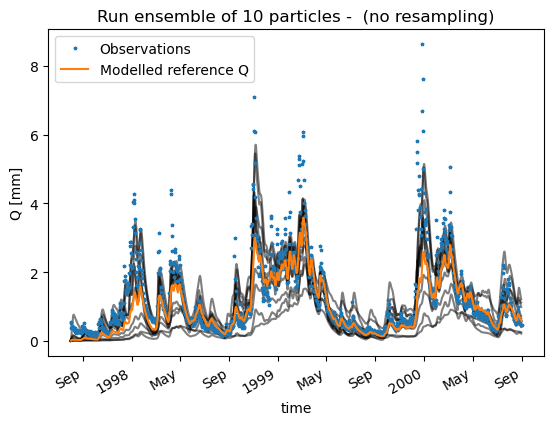

In [34]:
fig, ax = plt.subplots(1,1)
ds["Q"].plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=0,label="Observations")
ax.plot(df.index, Q_m_in_ref[1:],label="Modelled reference Q");
ax.legend(bbox_to_anchor=(1,1))
df_ensemble.plot(ax=ax,color="k",alpha=0.5,zorder=-1,legend=False)
ax.set_ylabel("Q [mm]")
ax.set_title(f"Run ensemble of {n_particles} particles -  (no resampling)");